In [2]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

'''
register_matplotlib_converters()
sns.set(style="whitegrid", palette= "muted", font_scale =1.5)
rcParams['figure.figsize']=22,10
'''

'\nregister_matplotlib_converters()\nsns.set(style="whitegrid", palette= "muted", font_scale =1.5)\nrcParams[\'figure.figsize\']=22,10\n'

In [3]:
device_info = tf.config.experimental.list_physical_devices('GPU')

if device_info:
    print("GPU is available. Details:")
    for device in device_info:
        print(device)
else:
    print("No GPU found. Using CPU.")

No GPU found. Using CPU.


In [4]:
path_train = 'data/train_data.npy'
path_test = 'data/test_data.npy'
path_test_label = 'data/test_labels.npy'

df_train = pd.DataFrame(np.load(path_train))
df_test =  pd.DataFrame(np.load(path_test))
y_df_test =  pd.DataFrame(np.load(path_test_label))

df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.000146,0.000565,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.000146,0.000565,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0
2,0.0,0.005520,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.000146,0.000565,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0
3,0.0,0.005801,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.000146,0.000565,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0
4,0.0,0.005576,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.000146,0.000565,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0


In [5]:
def data_engineering(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data)
    return scaled_df, scaler


df_train, train_scaler = data_engineering(df_train)
df_test, _ = data_engineering(df_test)

In [6]:
df_train = df_train.values.reshape((df_train.shape[0], df_train.shape[1], 1))
df_test = df_test.values.reshape((df_test.shape[0], df_test.shape[1], 1))

In [8]:
# LSTM model
'''
def get_model(input_shape):
    model = keras.Sequential()

    model.add(keras.layers.LSTM(units=128, input_shape=input_shape))
    model.add(keras.layers.Dropout(rate=0.2))

    model.add(keras.layers.RepeatVector(n=input_shape[0]))
    model.add(keras.layers.LSTM(units=128, return_sequences=True))

    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=input_shape[1])))

    model.compile(loss='mae', optimizer='adam')
    return model

'''

def get_lstm_autoencoder(input_shape):
    model = models.Sequential()

    # Encoder part: LSTM layers to learn the input sequence
    model.add(layers.LSTM(units=64, activation='relu', input_shape=input_shape, return_sequences=False))
    model.add(layers.RepeatVector(input_shape[0]))  # Repeat the encoded vector for the decoder

    # Decoder part: LSTM layers to reconstruct the original sequence
    model.add(layers.LSTM(units=64, activation='relu', return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(units=input_shape[1])))  # Reconstruct the sequence
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [9]:
input_shape = (df_train.shape[1], df_train.shape[2])
# model = get_model(input_shape)
model = get_lstm_autoencoder(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 repeat_vector (RepeatVector  (None, 41, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 41, 64)            33024     
                                                                 
 time_distributed (TimeDistr  (None, 41, 1)            65        
 ibuted)                                                         
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Training
history = model.fit(
    df_train,
    df_train,
    epochs=2, # 50
    batch_size=128,
    #validation_split=0.2,
    #shuffle=True
)

Epoch 1/2
3868/3868 [==============================] - 420s 109ms/step - loss: 0.7666
Epoch 2/2
3868/3868 [==============================] - 343s 89ms/step - loss: 0.7894


14060/14060 [==============================] - 314s 22ms/step


KeyError: 'val_loss'

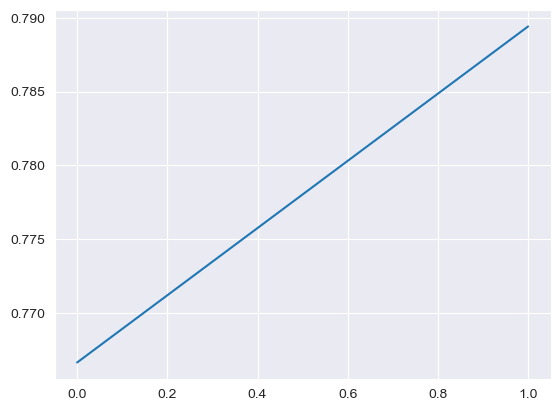

In [15]:
test_predictions = model.predict(df_test)

# Visualization
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Calculate reconstruction error 
reconstruction_error = np.mean(np.power(df_test - test_predictions, 2), axis=1) 

# Set a threshold for anomaly detection (e.g., 95th percentile) 
percentile = 95
threshold = np.percentile(reconstruction_error, percentile) 
# Identify anomalies 
predicted_anomalies = reconstruction_error > threshold 

# Calculate F1 score 
f1 = f1_score(y_df_test, predicted_anomalies) 
accuracy = accuracy_score(y_df_test, predicted_anomalies) 
precision = precision_score(y_df_test, predicted_anomalies) 
recall = recall_score(y_df_test, predicted_anomalies) 

print(f"percentile {percentile}")
print(f"Number of predicted anomalies {predicted_anomalies.sum()}: Number of actual anomalies {y_df_test.sum()}")
print(f"Accuracy: {accuracy:.2f}") 
print(f"Precision: {precision:.2f}") 
print(f"Recall: {recall:.2f}") 
print(f"F1-score: {f1:.2f}")

percentile 95
Number of predicted anomalies 22496: Number of actual anomalies 0    54584
dtype: int64
Accuracy: 0.93
Precision: 0.96
Recall: 0.40
F1-score: 0.56
